In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
# import powerlaw
import os

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0) # default plots are app. same size as notebook
plt.style.use('ggplot')

In [2]:
import warnings

# Ignore two specific warning messages from the powerlaw package. 
# Comment these lines to show warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

In [6]:
filepath = "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv"
cent_df = pd.read_csv(filepath, sep="\t")
cent_df.head()

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
0,3274717,8.922499e-07,1.135432e-06,60.801586,140.0,132.944440,178.0,1,16917
1,4318212,2.512850e-07,5.545155e-07,0.333333,4.0,7.666666,34.0,-1,19956
2,4561536,5.722828e-07,7.241771e-07,28.833334,166.0,96.222220,313.0,1,18352
3,4676031,4.102555e-07,7.383005e-07,8.750000,43.0,29.733334,120.0,1,16518
4,4848382,2.773767e-07,5.616168e-07,2.500000,8.0,1.500000,3.0,0,19160


## Fairness

In [25]:

def plot_group_dist(centrality_df, centrality, interval_size, max_N, protected_group, unprotected, 
                    show_unknown=True, field_name=None, na_removed=False, ax=None, global_rates=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    sorted_df = centrality_df.sort_values(by=centrality, ascending=False)
    
    if global_rates is not None:
        global_rate_protected = global_rates['protected']
        global_rate_unprotected = global_rates['unprotected']
    else:   
        global_rate_protected = sorted_df.Gender.value_counts(normalize=True)[protected_group]
        global_rate_unprotected = sorted_df.Gender.value_counts(normalize=True)[unprotected]
    
    normalizer = centrality_df.shape[0]
    
    xticks = []
    y_values = []
    y_values_unprotected = []
    y_values_unknown = []
    
    parity_x = None
    parity_pct = None
    
    for N in range(interval_size, max_N, interval_size):
        
        xticks.append((N / normalizer) * 100)
        top_n_df = sorted_df[:N]
        value_counts = top_n_df.Gender.value_counts(normalize=True)
        
        y_values.append(value_counts[protected_group] if protected_group in value_counts else 0)
        y_values_unprotected.append(value_counts[unprotected] if unprotected in value_counts else 0)
        
        abs_protected = abs(y_values[-1] - global_rate_protected)
        abs_unprotected = abs(y_values_unprotected[-1] - global_rate_unprotected)
        
        
        if parity_x is None and abs_protected <= 0.01 and abs_unprotected <= 0.01:
            parity_pct = (N / normalizer) * 100
            parity_x = N
        
        if show_unknown: y_values_unknown.append(value_counts[-1] if -1 in value_counts else 0)
    
    if show_unknown:
        global_rate_unknown = sorted_df.Gender.value_counts(normalize=True)[-1] \
        if global_rates is None else global_rates.get('unknown')
        ax.plot(xticks, y_values_unknown, '-o', label="N/A", markersize=3, color="#b8b8b8", alpha=0.2)
        ax.axhline(y=global_rate_unknown, label="Total population N/A", linestyle='--', alpha=0.8, color="#b8b8b8")
    
    
    ax.plot(xticks, y_values, '-o', label="Women", markersize=6, color="#6fc9f2")
    ax.axhline(y=global_rate_protected, label="Total population women", linestyle='--', alpha=1.0, color="#6fc9f2")
    
    
    ax.plot(xticks, y_values_unprotected, '-o', label="Men", markersize=6, color="#bd8aff")
    ax.axhline(y=global_rate_unprotected, label="Total population men", linestyle='--', alpha=1.0, color="#bd8aff")
    
    if parity_x is not None:
        ax.axvline(x=parity_pct, color="#ff8c00", linestyle='-', label='Parity ($\pm$ 1 %)')
        ax.text(parity_pct - 6, 0.55, "{:,} ({} %)".format(parity_x, int(parity_pct)), rotation=90, alpha=0.8,
                fontsize=20)
    
    if global_rates is None:
        title = "Group membership in Top N rank ({})".format(centrality)
        title += ": {}".format(field_name) if field_name is not None else ""
        title += " Increment = {}".format(interval_size)
        title += ". N/A removed" if na_removed else ""
        ax.set_title(title, fontsize=12)

    ax.set_ylabel("Proportion")
    ax.set_xlabel("Top N")
    
    ax.legend()
    
    if ax is None:
        plt.show()
    
    return y_values, xticks



def plot_side_by_side(cent_df, field_name, interval=1000, figsize=(15,12), centrality="Pagerank",
                      filepath=None):
    idx = 0
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=figsize, sharex=False, sharey=True)
    axs = list(axs.flatten())
    
    labelsize = 28
    
    plt.rcParams['axes.labelsize'] = 16
    
    global_rates = {
        'protected': cent_df.Gender.value_counts(normalize=True)[0],
        'unprotected': cent_df.Gender.value_counts(normalize=True)[1],
        'unknown': cent_df.Gender.value_counts(normalize=True)[-1]
    }
    
    cent_df.sort_values(by=centrality, ascending=False, inplace=True)
    
    plot_group_dist(cent_df, centrality, 
                    interval_size=interval, 
                    max_N=len(cent_df), 
                    protected_group=0, 
                    unprotected=1,
                    field_name=field_name, 
                    ax=axs[0], global_rates=global_rates)
    
    axs[0].set_title("Top 100 % of N = {:,} \n Increment = {}".format(cent_df.shape[0], interval), 
                     fontsize=labelsize - 3, color='#363534')
    centrality_format = r"$\bf{" + centrality.replace(" ", "\ ") + "}$"
    
    axs[0].set_ylabel( centrality_format + "\nGender prop. in top N", fontsize=labelsize + 2)
    
    if centrality == 'PageRank':
        axs[0].legend(fontsize=labelsize - 10, loc='lower right').set_visible(True)
    else:
        axs[0].legend(fontsize=labelsize - 6, loc='lower right').set_visible(False)
    
    # axs[0].set_yticklabels(axs[0].get_yticklabels(),fontsize=labelsize)
    axs[0].tick_params(axis='y', labelsize=labelsize + 6)
    
    axs[0].set_ylim(-0.05, 1.05)
    # normalize x-axis
    #axs[0].set_xticks( axs[0].get_xticks() / axs[0].get_xticks().max() )
    
    #axs[2].get_xticks() / axs[1].get_xticks().max()
    #axs[2].get_xticks() / axs[1].get_xticks().max()
    
    
    
    cent_df_filtered = cent_df.query("Gender != -1")
    
    global_rates = {
        'protected': cent_df_filtered.Gender.value_counts(normalize=True)[0],
        'unprotected': cent_df_filtered.Gender.value_counts(normalize=True)[1],
    }
    
    y, x = plot_group_dist(cent_df_filtered, centrality, 
                           interval_size=interval,
                           max_N=len(cent_df_filtered), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[1],
                           global_rates=global_rates)
    axs[1].set_title("Top 100 % of N = {:,}\n Increment = {}. N/A removed".format(cent_df_filtered.shape[0], 
                                                                               interval), fontsize=labelsize - 3,
                    color='#363534')
    axs[1].set_ylabel(None)
    axs[1].legend().set_visible(False)
    
    # 10 %
    cent_df_filtered_ten = cent_df_filtered[:int(cent_df_filtered.shape[0] * 0.1)]
    y, x = plot_group_dist(cent_df_filtered_ten, centrality, 
                           interval_size=100,
                           max_N=len(cent_df_filtered_ten), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[2],
                           global_rates=global_rates)
    axs[2].set_title("Top 10 % of N = {:,}\n Increment = {}. N/A removed".format(cent_df_filtered.shape[0],
                                                                               100), 
                     fontsize=labelsize - 3, color='#363534')
    axs[2].set_ylabel(None)
    axs[2].legend().set_visible(False)
    
    
    cent_df_filtered_one = cent_df_filtered[:int(cent_df_filtered.shape[0] * 0.01)]
    y, x = plot_group_dist(cent_df_filtered_one, centrality, 
                           interval_size=10,
                           max_N=len(cent_df_filtered_one), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[3],
                           global_rates=global_rates)
    
    axs[3].set_title("Top 1 % of N = {:,} \n Increment = {}. N/A removed".format(cent_df_filtered.shape[0], 10), 
                     fontsize=labelsize - 3, color='#363534')
    axs[3].set_ylabel(None)
    axs[3].legend(fontsize=13, loc='right').set_visible(False)
    
    plt.suptitle("Gender distribution in top N rankings in " + r"$\bf{" + field_name + "}$", 
                 fontsize=labelsize + 4, color='#363534')
    plt.tight_layout()
    
    maxval = cent_df.shape[0]
    
    
    xticks = []
    for tick in axs[2].get_xticklabels()[1:-1]:
        tick.set_text("{}".format(int(tick._x / 10)))
        xticks.append(tick)
    axs[2].set_xticklabels(xticks, fontsize=labelsize)
    axs[2].set_xlabel('% of top N', fontsize=labelsize)
    
    
    xticks = []
    for tick in axs[3].get_xticklabels()[1:-1]:
        tick.set_text("{0:.1f}".format(tick._x / 100))
        xticks.append(tick)

    axs[3].set_xticklabels(xticks, fontsize=labelsize)
    axs[3].set_xlabel('% of top N', fontsize=labelsize)
    
    axs[3].labelsize = 30

    
    for i in range(4):
        axs[i].set_xticks([0. ,  20,  40,  60,  80,  100])
        axs[i].set_xlabel('% of top N', fontsize=labelsize)
        axs[i].tick_params(axis='x', labelsize=labelsize + 10, rotation=90)
    
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.2)
        
    return axs


<ipython-input-25-c2a44f85e0c9>:202: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
<ipython-input-25-c2a44f85e0c9>:211: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


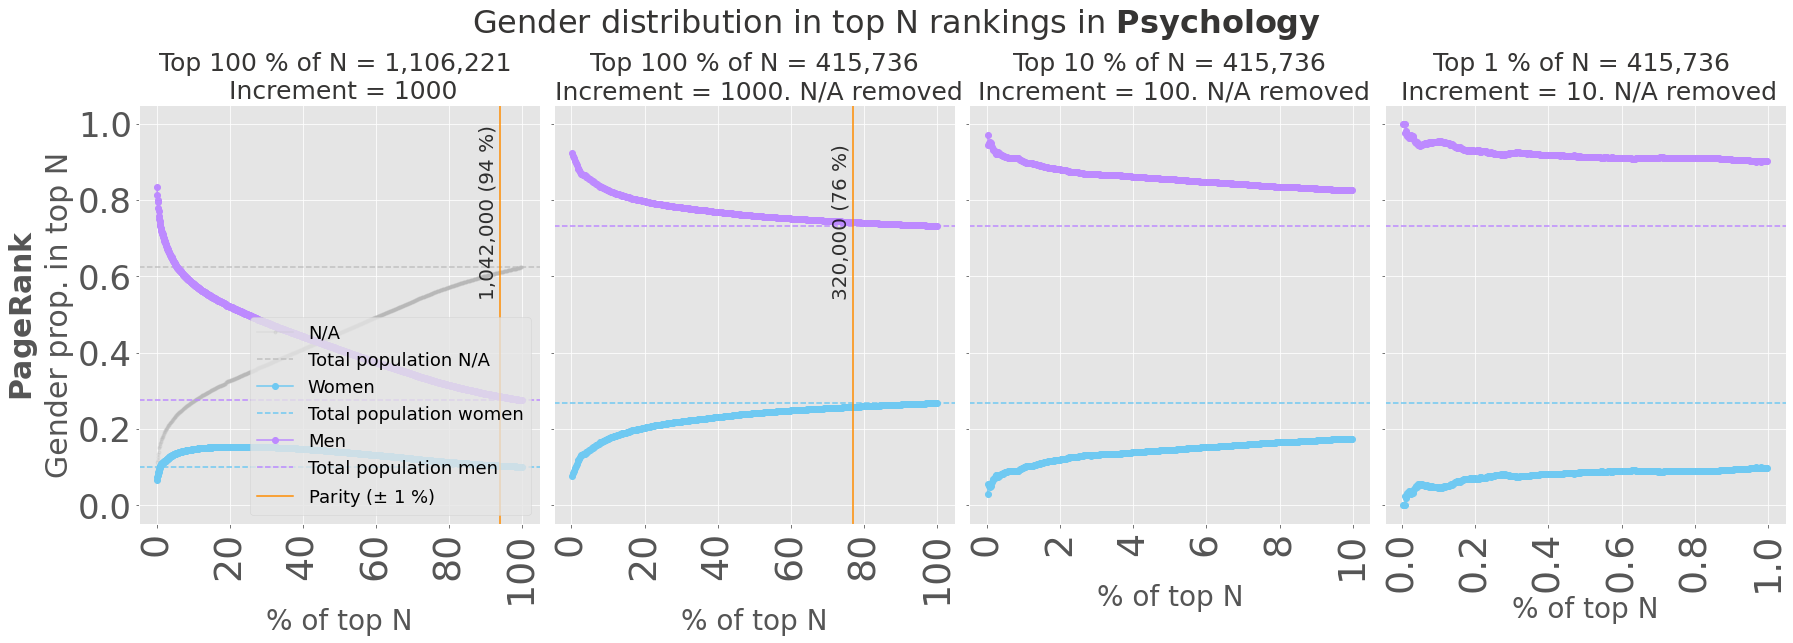

In [26]:
axs = plot_side_by_side(cent_df, 'Psychology', interval=1000, 
                        figsize=(25,8), centrality="PageRank", filepath="test_graph.png")

In [38]:
axs[0].get_yticklabels()

[Text(0, -0.2, ''),
 Text(0, 0.0, ''),
 Text(0, 0.2, ''),
 Text(0, 0.4000000000000001, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0000000000000002, ''),
 Text(0, 1.2000000000000002, '')]

In [31]:
axs[0].get_xticks() / axs[0].get_xticks().max()

array([-0.16666667,  0.        ,  0.16666667,  0.33333333,  0.5       ,
        0.66666667,  0.83333333,  1.        ])

In [32]:
axs[0].get_xticks()

array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2])

In [20]:
axs[2].get_xticks() / axs[1].get_xticks().max()

array([-0.01666667,  0.        ,  0.01666667,  0.03333333,  0.05      ,
        0.06666667,  0.08333333,  0.1       ])

In [21]:
cent_df[:10]

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
1895323,968460832,0.001325,0.000528,19650.7770,17658.0,3.000000,3.000000,1,11308
1202609,2137065126,0.001166,0.000684,49866.9960,54321.0,3666.764200,3666.764200,1,11038
125279,467622467,0.000947,0.000436,22329.7500,27923.0,19.166666,19.166666,0,11565
1336062,2490080893,0.000879,0.000300,15904.7740,13884.0,1159.166600,1159.166600,-1,12048
1690847,1982301990,0.000768,0.000328,20830.6370,24780.0,5633.717000,5633.717000,-1,12042
577524,355673734,0.000717,0.000171,3242.3833,4578.0,27.500000,27.500000,-1,12201
2020262,1969121271,0.000683,0.000157,4560.8477,6147.0,214.250000,214.250000,1,12619
1698296,2157867866,0.000659,0.000352,11459.1980,25321.0,31.500000,31.500000,1,12516
334913,2026186952,0.000618,0.000274,10341.3920,19441.0,382.833340,382.833340,1,12640
256964,2134451896,0.000605,0.000241,12156.9890,17248.0,143.683330,143.683330,1,11875


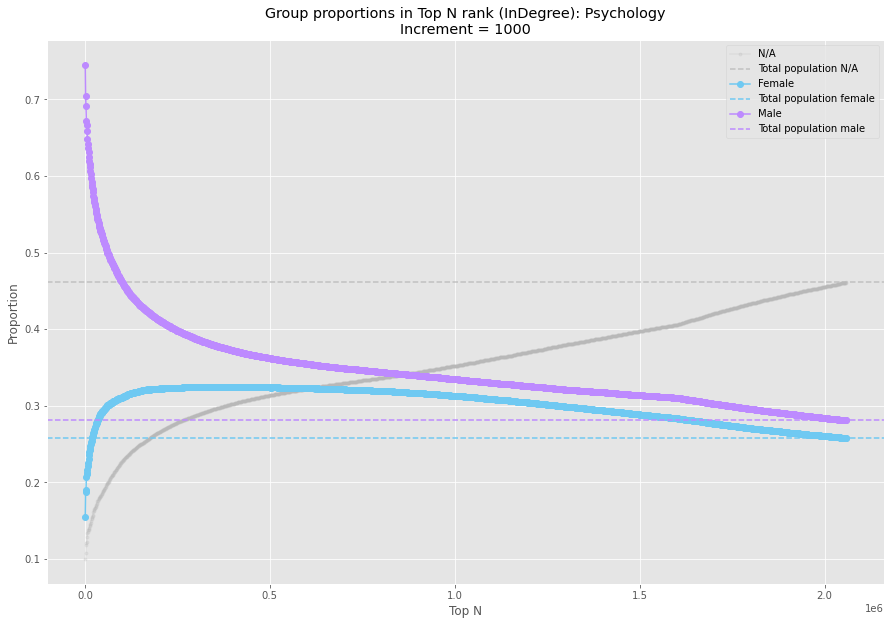

In [21]:
y, x = plot_group_dist(cent_df, 'InDegree', interval_size=1000, max_N=len(cent_df), protected_group=0, unprotected=1,
                       field_name="Psychology")

In [19]:
cent_df_filtered = cent_df.query("Gender != -1")

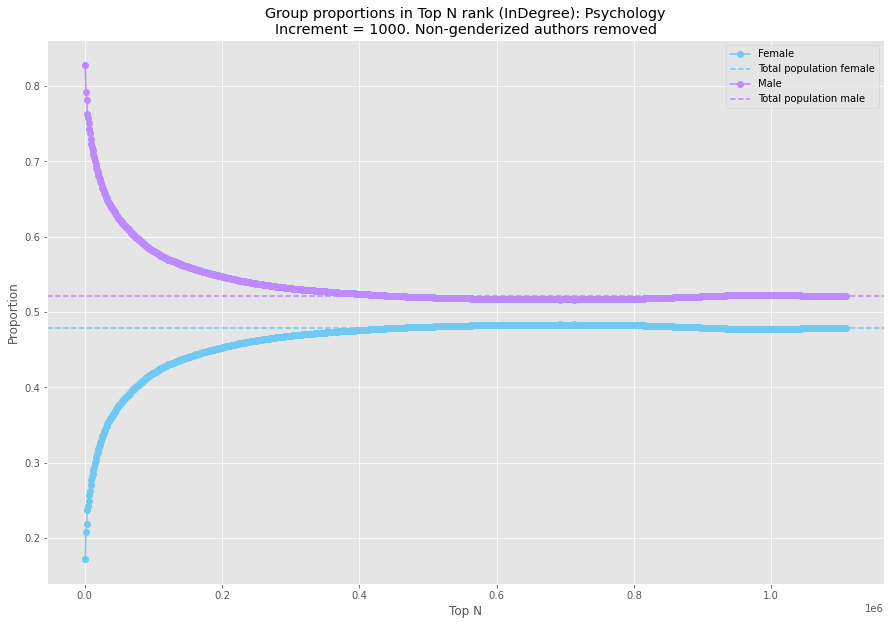

In [20]:
y, x = plot_group_dist(cent_df_filtered, 'InDegree', interval_size=1000, max_N=len(cent_df_filtered), 
                       protected_group=0, 
                       unprotected=1, 
                       show_unknown=False,
                       na_removed=True,
                       field_name="Psychology")

In [9]:
def read_author_metadata(fos_id=162324750):
    base_destination = "/home/laal/MAG/DATA/AuthorMetadataField.csv"
    
    columns = ['AuthorId', 'FieldOfStudyId', 'Gender', 'MinAffiliationRank', 'NumPapers', 'MinPubDate', 'MaxPubDate', 'PubsPerYear']
    
    author_df = pd.DataFrame()
    
    for file in os.listdir(base_destination):
        if file.endswith('.csv'):
            df = pd.read_csv(base_destination + "/" + file, names=columns, sep="\t")
            author_df = pd.concat([author_df, df.query("FieldOfStudyId == {}".format(fos_id))])
    
    # parse datetimes
    author_df['MinPubDate'] = pd.to_datetime(author_df['MinPubDate'])
    author_df['MaxPubDate'] = pd.to_datetime(author_df['MaxPubDate'])
    
    author_df['MinPubYear'] = author_df['MinPubDate'].apply(lambda x: x.year)
    author_df['MaxPubYear'] = author_df['MaxPubDate'].apply(lambda x: x.year)
    
    return author_df



def plot_all_fields(centrality, interval=1000, num_papers_min=None):
    
    field_ids = {
        "Psychology": 15744967,
        "Economics": 162324750, 
        "Mathematics": 33923547,
        "Chemistry": 185592680,
    }
    
    field_mapping = {
        "Psychology": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2020CentralityGendered.csv",
        "Economics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv", 
        "Mathematics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightMathematics2020CentralityGendered.csv",
        "Chemistry": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightChemistry2020CentralityGendered.csv",
    }
    
    for field_name, fpath in field_mapping.items():
        
        cent_df = pd.read_csv(fpath, sep="\t")
        cent_df['MAG Rank'] = cent_df['Rank'].apply(lambda x: x*-1)
        
        if centrality == 'Rank':
            centrality = 'MAG Rank'
                
        if num_papers_min is not None:
            
            author_meta = read_author_metadata(fos_id=field_ids[field_name])
            
            authors = author_meta.query("NumPapers > {}".format(num_papers_min))['AuthorId'].values
            
            cent_df = cent_df[cent_df.AuthorId.isin(authors)]
            
                
        plot_side_by_side(cent_df, field_name, interval=1000, figsize=(25,8), centrality=centrality)
        

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


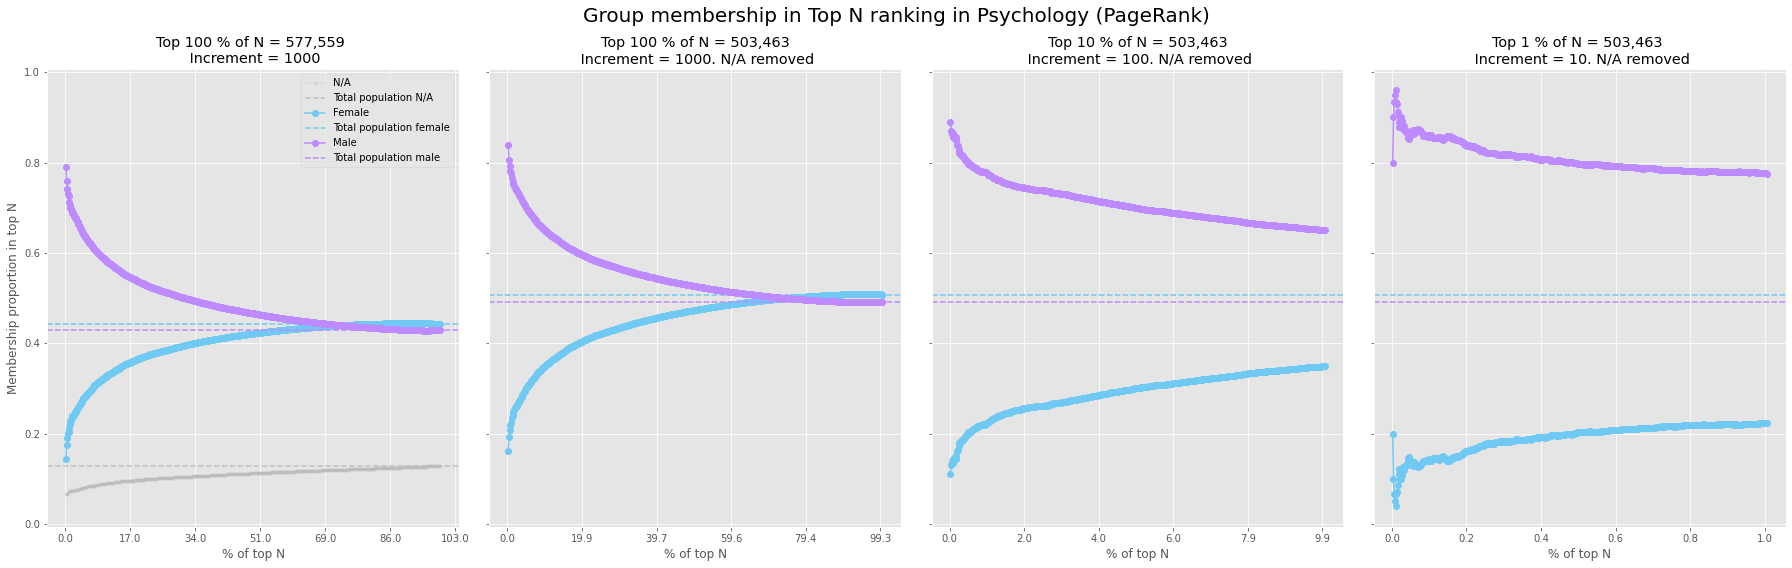

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


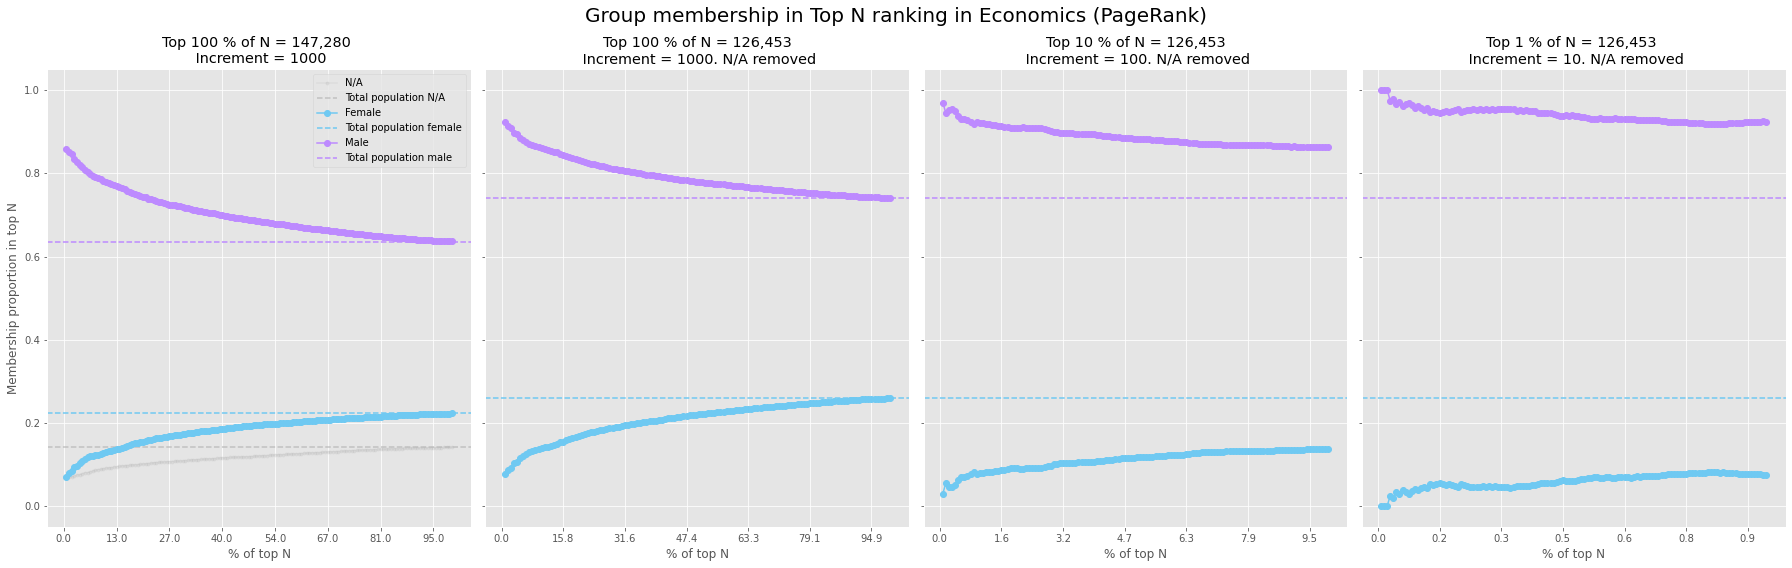

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


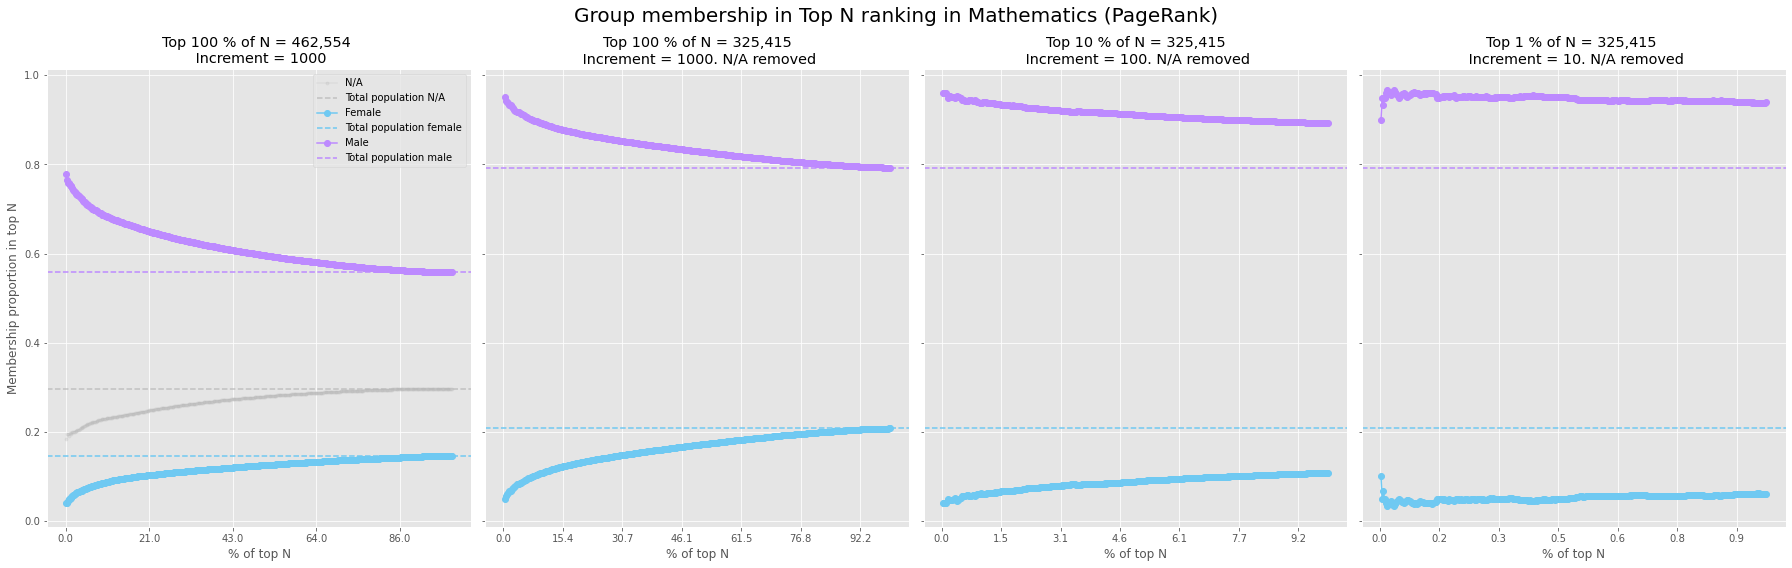

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


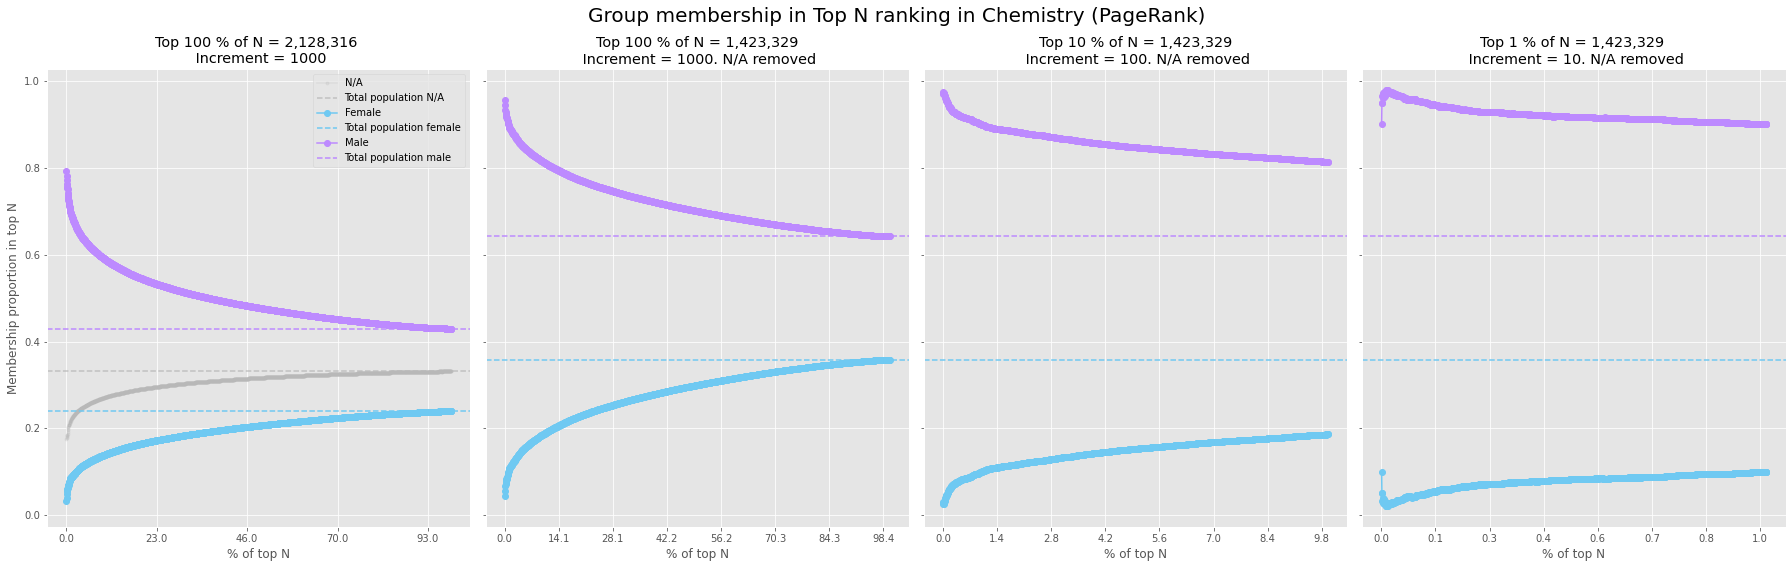

In [10]:
plot_all_fields('PageRank', 1000, num_papers_min=1)

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


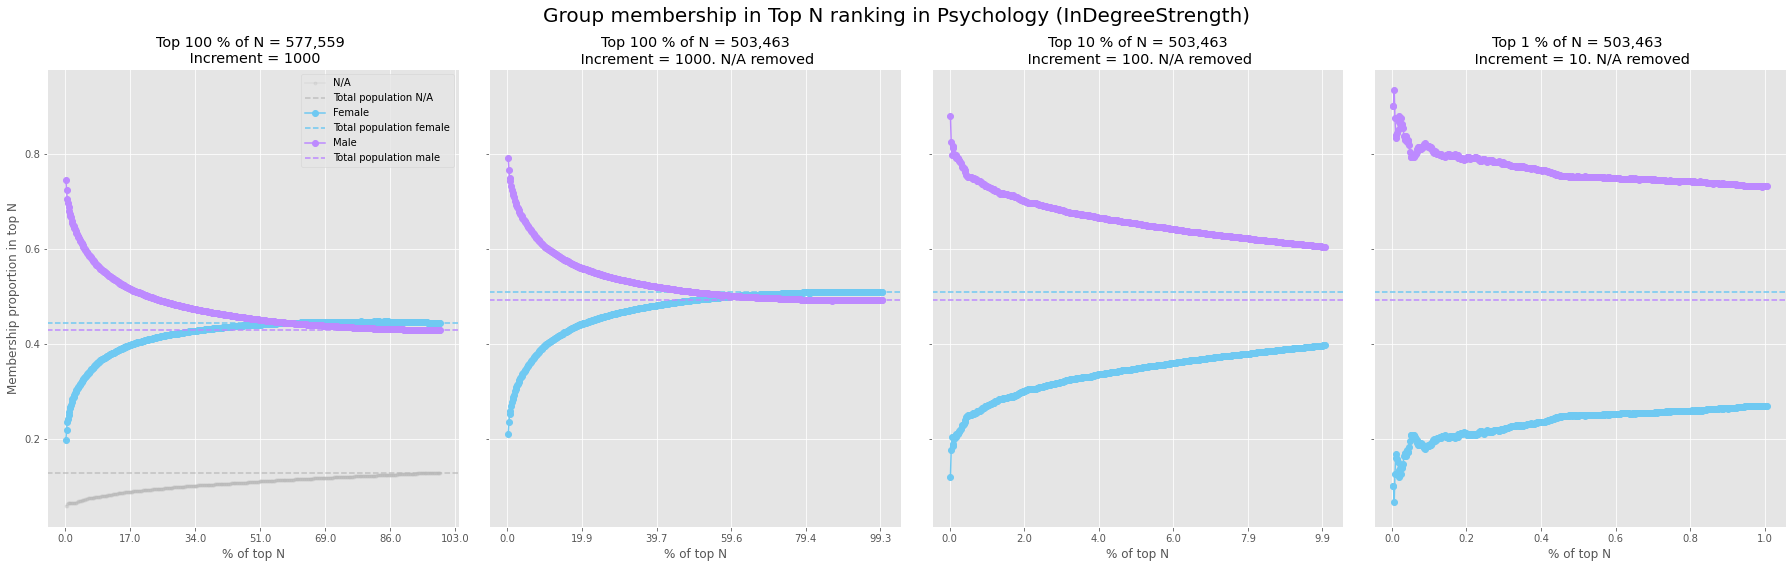

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


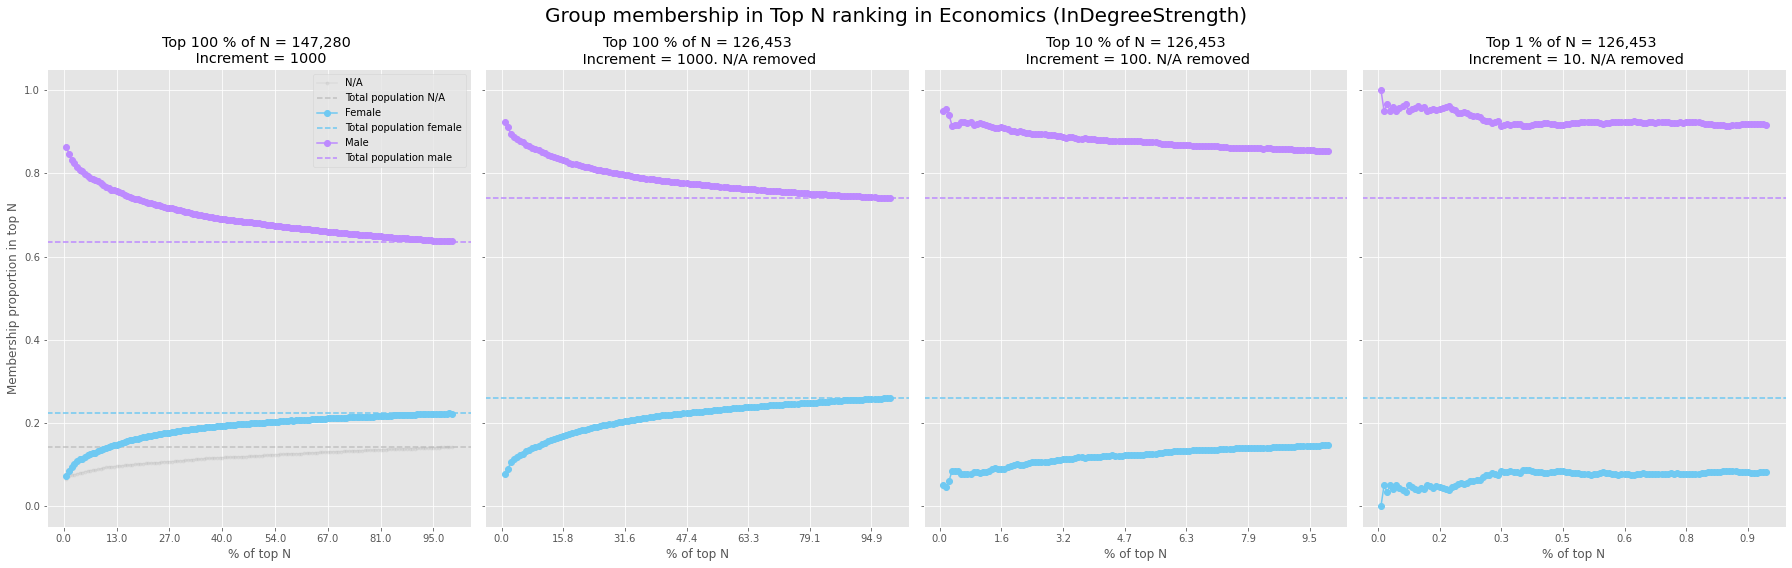

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


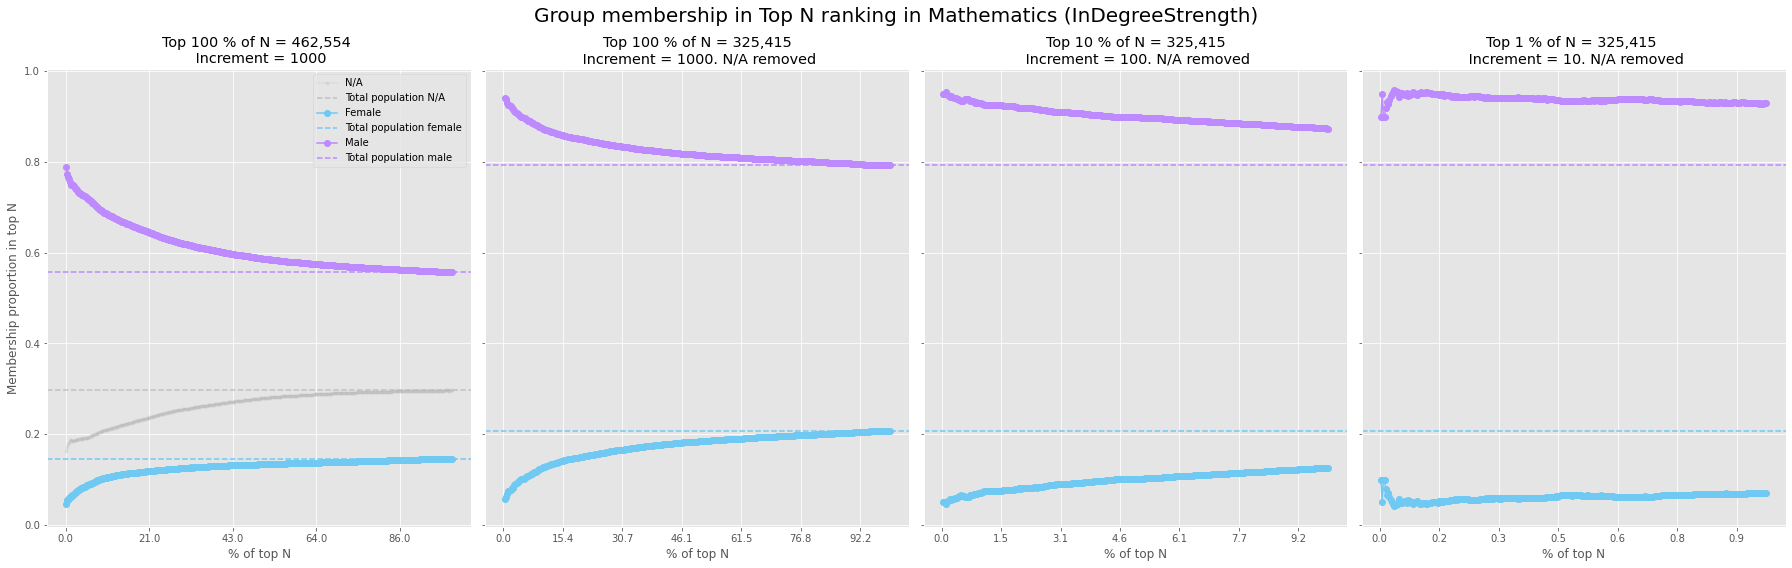

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


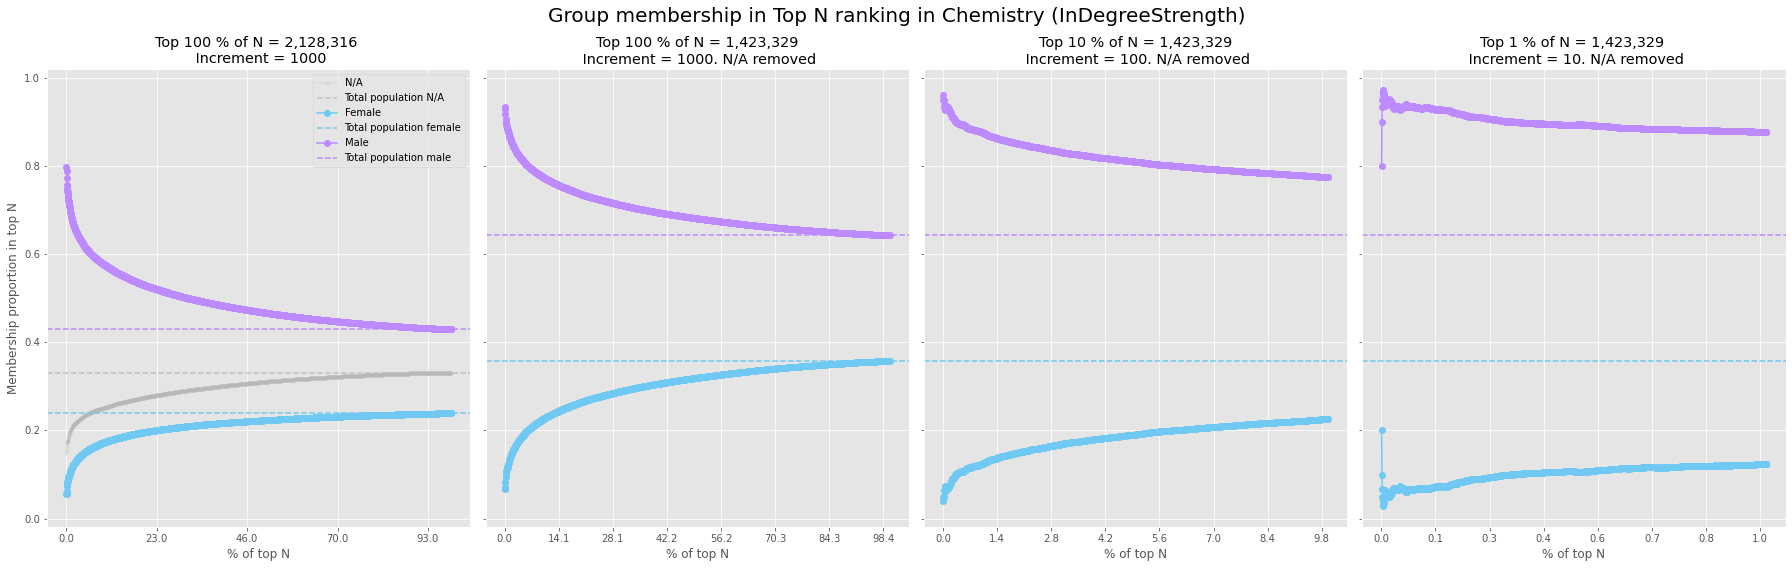

In [11]:
plot_all_fields('InDegreeStrength', 1000, num_papers_min=1)

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


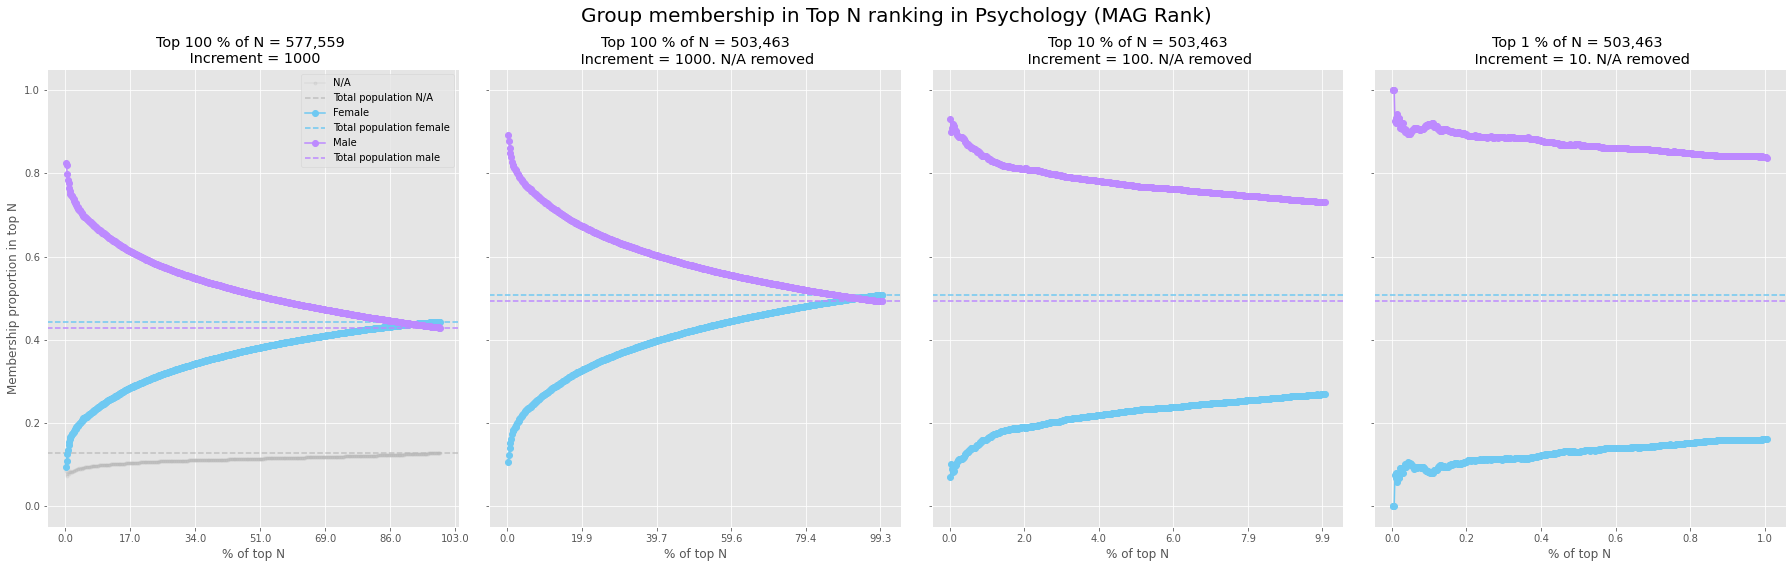

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


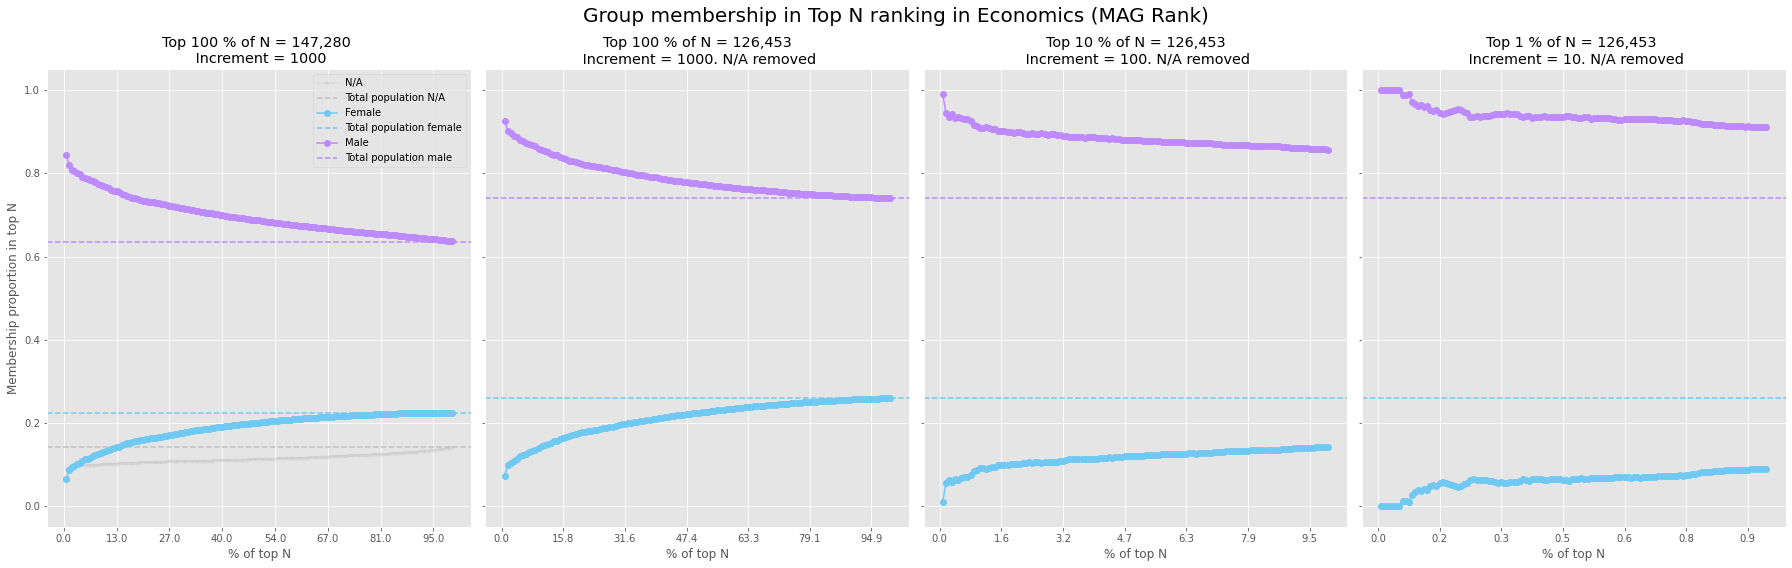

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


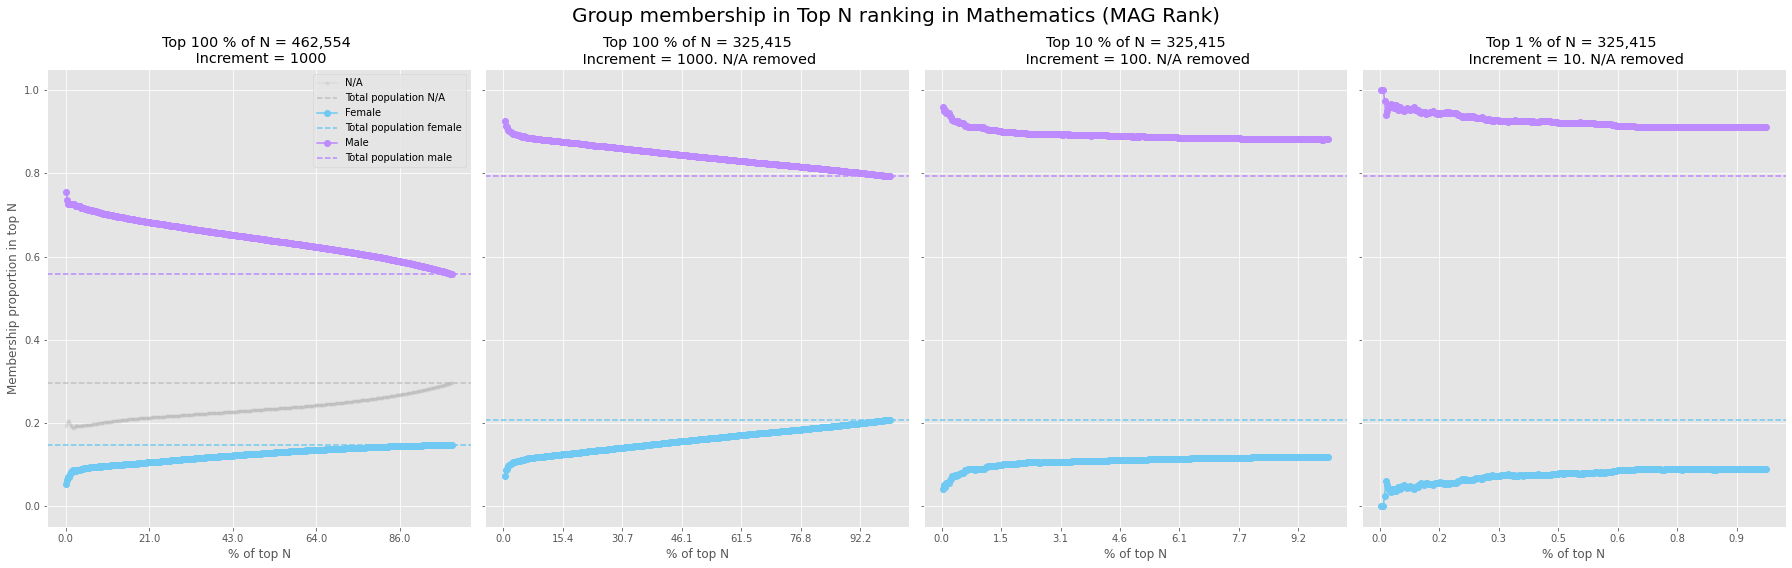

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


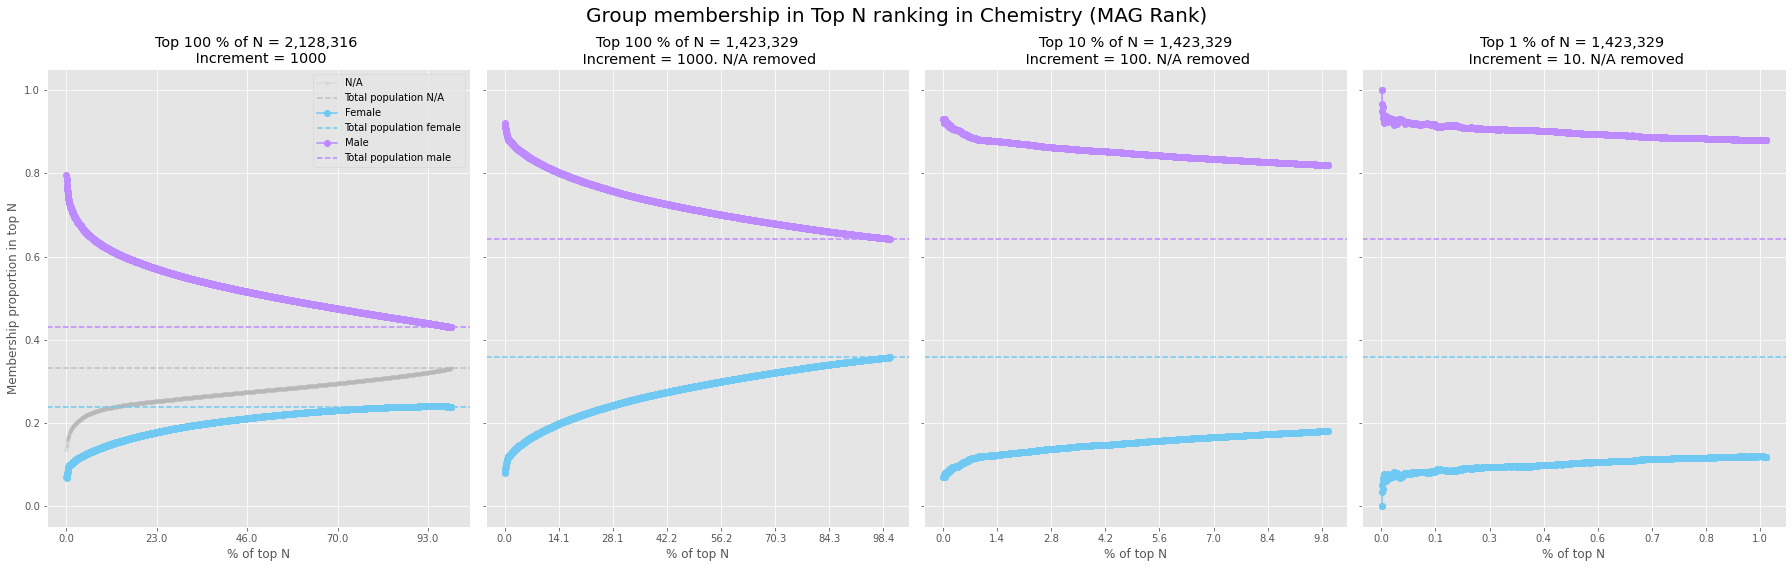

In [12]:
plot_all_fields('Rank', 1000, num_papers_min=1)

In [36]:
def plot_group_dist_stacked(centrality_df, centrality, interval_size, max_N, protected_group, unprotected, 
                            show_unknown=True, field_name=None, na_removed=False, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    df = pd.DataFrame()
    
    sorted_df = centrality_df.sort_values(by=centrality, ascending=False)
    
    global_rate_protected = sorted_df.Gender.value_counts(normalize=True)[protected_group]
    global_rate_unprotected = sorted_df.Gender.value_counts(normalize=True)[unprotected]
    
    
    xticks = []
    y_values = []
    y_values_unprotected = []
    y_values_unknown = []
    
    for N in range(interval_size, max_N, interval_size):
        
        xticks.append(N)
        top_n_df = sorted_df[:N]
        y_values.append(top_n_df.Gender.value_counts(normalize=True)[protected_group])
        y_values_unprotected.append(top_n_df.Gender.value_counts(normalize=True)[unprotected])
        
        if show_unknown: y_values_unknown.append(top_n_df.Gender.value_counts(normalize=True)[-1])
    
    
    
    if show_unknown:
        global_rate_unknown = sorted_df.Gender.value_counts(normalize=True)[-1]
        ax.plot(xticks, y_values_unknown, '-o', label="N/A", markersize=3, color="#b8b8b8", alpha=0.2)
        ax.axhline(y=global_rate_unknown, label="Total population N/A", linestyle='--', alpha=0.8, color="#b8b8b8")
    
    
    
    
    df['Female'] = y_values
    df['Male'] = y_values_unprotected
    
    df.index = xticks
    
    if show_unknown:
        df['N/A'] = y_values_unknown

        
    ax = df.plot.area(stacked=True, ax=ax, alpha=0.8, linewidth=0)
        
    colors = ["#6fc9f2", "#bd8aff", "#b8b8b8"]
        
    for index, collection in enumerate(ax.collections):
        collection.set_facecolor(colors[index])
        
    #ax.plot(xticks, y_values, '-o', label="Female", markersize=6, color="#6fc9f2")
    
    ax.axhline(y=global_rate_protected, label="Total population female", linestyle='--', alpha=1.0, color="#6fc9f2")
    
    
    #ax.plot(xticks, y_values_unprotected, '-o', label="Male", markersize=6, color="#bd8aff")
    ax.axhline(y=global_rate_unprotected, label="Total population male", linestyle='--', alpha=1.0, color="#bd8aff")
    
    
    title = "Group proportions in Top N rank ({})".format(centrality)
    title += ": {}".format(field_name) if field_name is not None else ""
    title += "\nIncrement = {}".format(interval_size)
    title += ". Non-genderized authors removed" if na_removed else ""
    
    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Top N")
    
    ax.legend()
    
    if ax is None:
        plt.show()
    
    return y_values, xticks

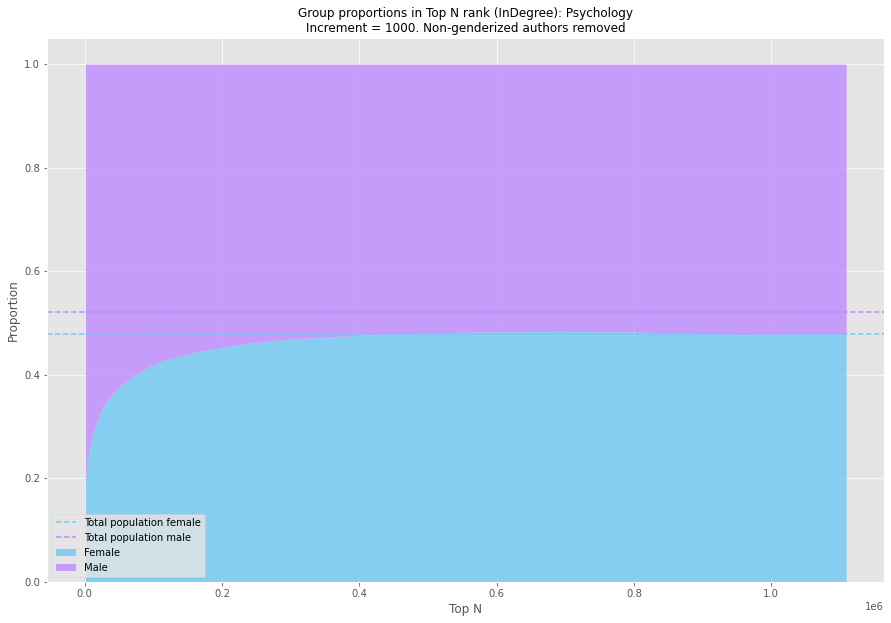

In [37]:
y, x = plot_group_dist_stacked(cent_df_filtered, 'InDegree', interval_size=1000, max_N=len(cent_df_filtered), 
                       protected_group=0, 
                       unprotected=1, 
                       show_unknown=False,
                       na_removed=True,
                       field_name="Psychology")

<AxesSubplot:ylabel='Frequency'>

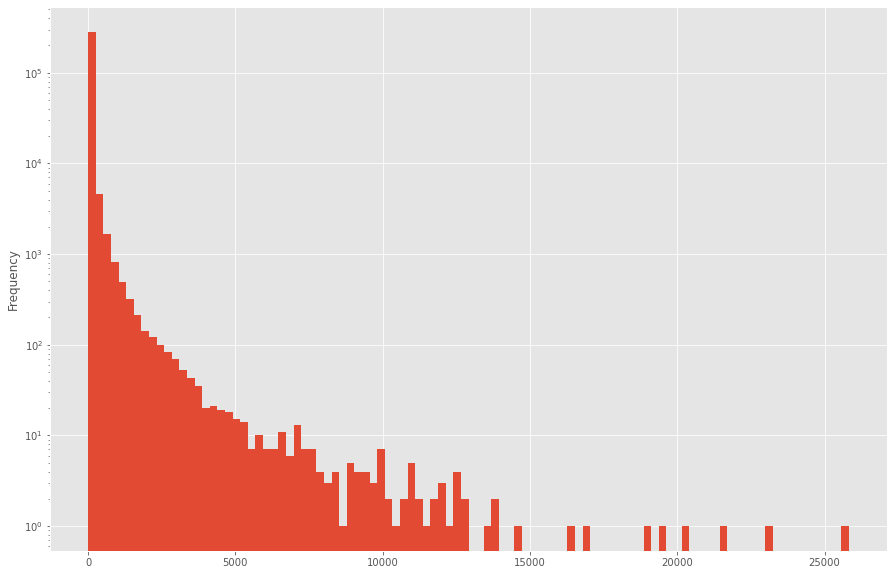

In [105]:
cent_df_filtered['InDegree'].plot(kind='hist', bins=100, log=True)

In [97]:
cent_df_filtered[['PageRank', 'Rank']].corr()

,PageRank,Rank
PageRank,1.000000,-0.162985
Rank,-0.162985,1.000000


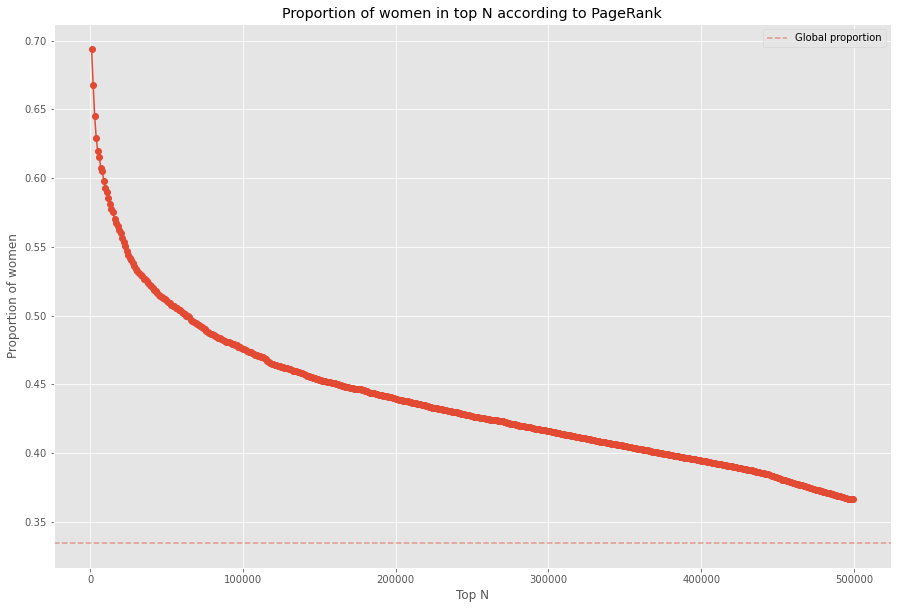

In [55]:
y,x = plot_group_dist(cent_df, 'PageRank', interval_size=1000, max_N=500000, protected_group=1)

In [29]:
cent_df[:11]

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
0,29087,7.099961e-07,0.000001,1.000000,1.0,0.000000,0.000000,-1,19035
1,599318,1.577505e-06,0.000002,1.000000,3.0,1.333333,1.333333,1,16691
2,869659,7.109015e-07,0.000001,0.600000,4.0,0.000000,0.000000,0,20475
3,1671721,1.130131e-05,0.000008,70.833336,199.0,35.166668,35.166668,0,12736
4,2069880,9.996813e-07,0.000001,1.375000,13.0,0.500000,0.500000,-1,16284
5,2128505,6.835849e-07,0.000001,0.000000,0.0,7.000000,7.000000,1,16842
6,2755080,6.835849e-07,0.000001,0.000000,0.0,7.500000,7.500000,-1,18157
7,3381675,9.267146e-07,0.000001,1.500000,4.0,1.000000,1.000000,0,18399
8,3546215,6.926638e-07,0.000001,0.500000,1.0,5.000000,5.000000,1,17172
9,3791134,8.106969e-07,0.000001,3.500000,14.0,23.000000,23.000000,1,16825


## Fairness measure comparison

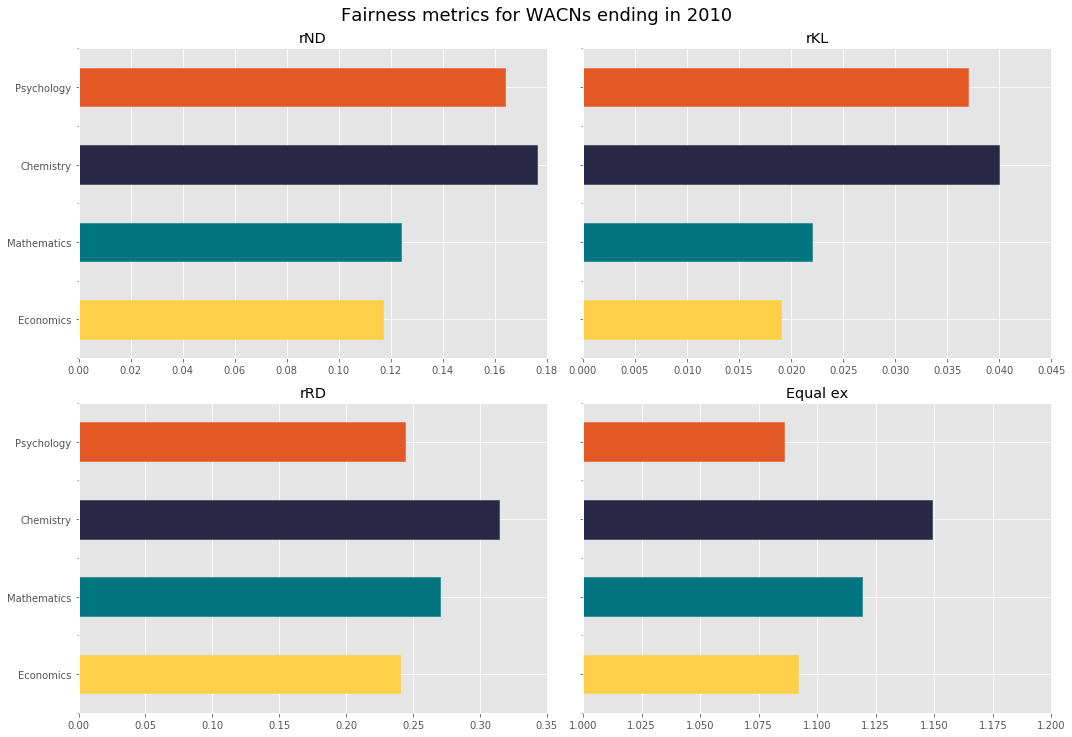

In [55]:
data = [[0.117, 0.019, 0.240, 1.092],
        [0.124, 0.022, 0.270, 1.119], 
        [0.176, 0.040, 0.314, 1.149],
        [0.164, 0.037, 0.244, 1.086]]

names = ['Economics', 'Mathematics', 'Chemistry', 'Psychology']

xlims = [(0, 0.18), (0, 0.045), (0, 0.35), (1, 1.2)]

fairness_df = pd.DataFrame(data, columns=['rND', 'rKL', 'rRD', 'Equal ex'], 
                           index=names)

output = fairness_df.plot(kind='barh', subplots=True, layout=(2,2), sharex=False,
                         legend=None, sharey=True)

colors = ['#fed049', '#007580', '#282846', '#e45826']


for index, chart in enumerate(output.flatten()):    
    for idx, patch in enumerate(chart.patches):
        patch.set_color(colors[idx])
    
    chart.set_xlim(xlims[index])
        
plt.suptitle("Fairness metrics for WACNs ending in 2010", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [50]:
output.flatten()[0].set_title()

TypeError: set_title() missing 1 required positional argument: 'label'

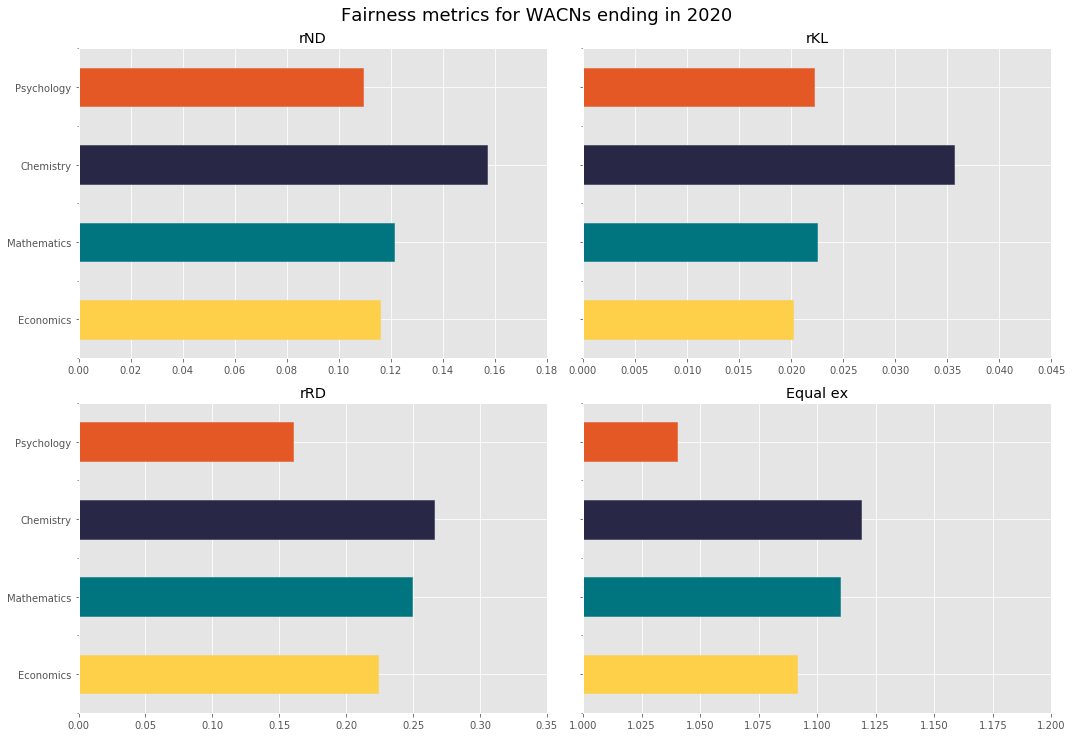

In [56]:
data = [[0.11593, 0.02018, 0.223787, 1.09122],
        [0.121057, 0.022437, 0.24905, 1.1097050], 
        [0.156861, 0.035671, 0.2654512,1.11853],
        [0.10930,0.02223, 0.16049, 1.04017]]

names = ['Economics', 'Mathematics', 'Chemistry', 'Psychology']

xlims = [(0, 0.18), (0, 0.045), (0, 0.35), (1, 1.2)]

fairness_df = pd.DataFrame(data, columns=['rND', 'rKL', 'rRD', 'Equal ex'], 
                           index=names)

output = fairness_df.plot(kind='barh', subplots=True, layout=(2,2), sharex=False,
                         legend=None, sharey=True)

colors = ['#fed049', '#007580', '#282846', '#e45826']


for index, chart in enumerate(output.flatten()):    
    for idx, patch in enumerate(chart.patches):
        patch.set_color(colors[idx])
    
    chart.set_xlim(xlims[index])
        
plt.suptitle("Fairness metrics for WACNs ending in 2020", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [40]:
output.flatten()

array([<AxesSubplot:title={'center':'rND'}>,
       <AxesSubplot:title={'center':'rKL'}>,
       <AxesSubplot:title={'center':'rRD'}>,
       <AxesSubplot:title={'center':'Equal ex'}>], dtype=object)

In [38]:
output[0][0].patches[0].set_color()

<bound method Patch.set_color of <matplotlib.patches.Rectangle object at 0x7f443079de50>>

In [15]:
def zero_indegree():
    
    field_mapping = {
        "Psychology": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2020CentralityGendered.csv",
        "Economics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv", 
        "Mathematics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightMathematics2020CentralityGendered.csv",
        "Chemistry": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightChemistry2020CentralityGendered.csv",
    }
    
    for field_name, fpath in field_mapping.items():
        
        cent_df = pd.read_csv(fpath, sep="\t").query("Gender != -1")
        cent_df['MAG Rank'] = cent_df['Rank'].apply(lambda x: x * -1)
        
        zero = cent_df[cent_df.InDegreeStrength <= 0]
        print("Proportion with 0 in-degre strength in {}: {} / {} = {}"
             .format(field_name, len(zero), len(cent_df), len(zero) / len(cent_df)))

In [16]:
zero_indegree()

Proportion with 0 in-degre strength in Psychology: 157674 / 1623660 = 0.09711023243782566
Proportion with 0 in-degre strength in Economics: 57760 / 415736 = 0.13893432370542844
Proportion with 0 in-degre strength in Mathematics: 194932 / 969237 = 0.2011190245523025
Proportion with 0 in-degre strength in Chemistry: 317841 / 3935075 = 0.08077126865434585


## Slices


In [81]:
import numpy as np


def plot_slices(figsize=(12,8)):

    colors = {
    'Psychology': '#3f2cfd',
    'Chemistry' : '#282846',
    'Mathematics': '#007580',
    'Economics': '#fed049'
    }
    
    labelsize = 18
    
    slice_dfs = []
    
    idx = 0
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize, sharex=True, sharey=True)
    axs = list(axs.flatten())
    
    for field, color in colors.items():
        
        slices_scores = pd.read_csv('/home/laal/MAG/CentralityFairness/EVALUATIONS_OUTPUTS/{}_slices_filtered.csv'
                                        .format(field.lower()))
        slices = pd.read_csv('/home/laal/MAG/CentralityFairness/SLICES/{}2020.csv'.format(field), 
                             parse_dates=['pubDate_lower', 'pubDate_upper'])
        
        slices['midTime'] = slices['pubDate_lower'] + ((slices.pubDate_upper - slices.pubDate_lower) / 2)
        slices = pd.merge(slices, slices_scores, left_on='slice_index', right_on='index')

        slices = slices.query("centrality == 'PageRank'")
        
        slice_dfs.append(slices)
        

        
        pd.Series(slices.rND.values, index=slices.midTime)\
        .plot(style='-o', label=field, color=color, ax=axs[idx])
        # pd.Series(econ_slices.rND.values, index=econ_slices.midTime).plot(style='-o', label='Economics')
        # plt.xticks(psych_slices.pubDate_lower.values)
        
        

        axs[idx].tick_params(axis='x', labelsize=labelsize + 2, rotation=90 )
        axs[idx].tick_params(axis='y', labelsize=labelsize + 2)
        
        axs[idx].set_title(field, fontsize=labelsize + 2)
        
        axs[idx].set_xlabel('Midpoint of time interval', fontsize=labelsize)
        axs[idx].set_ylabel('rND ', fontsize=labelsize)
        
        idx += 1
    # axs.set_xticklabels(xticks, fontsize=labelsize)
        
    plt.xlim((np.datetime64('1960-02-25'), np.datetime64('2022-02-25')))
    plt.suptitle("rND for homogeneous WACNs over time \n Ranking: PageRank", fontsize=labelsize + 4, color='#363534')
    
    
    # plt.legend(fontsize=labelsize)

    plt.tight_layout()
    plt.show()        
    
    return slice_dfs
    

/home/laal/.conda/envs/magenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/laal/.conda/envs/magenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/laal/.conda/envs/magenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/laal/.conda/envs/magenv/lib/python3.8/site-packages/pandas/plotting

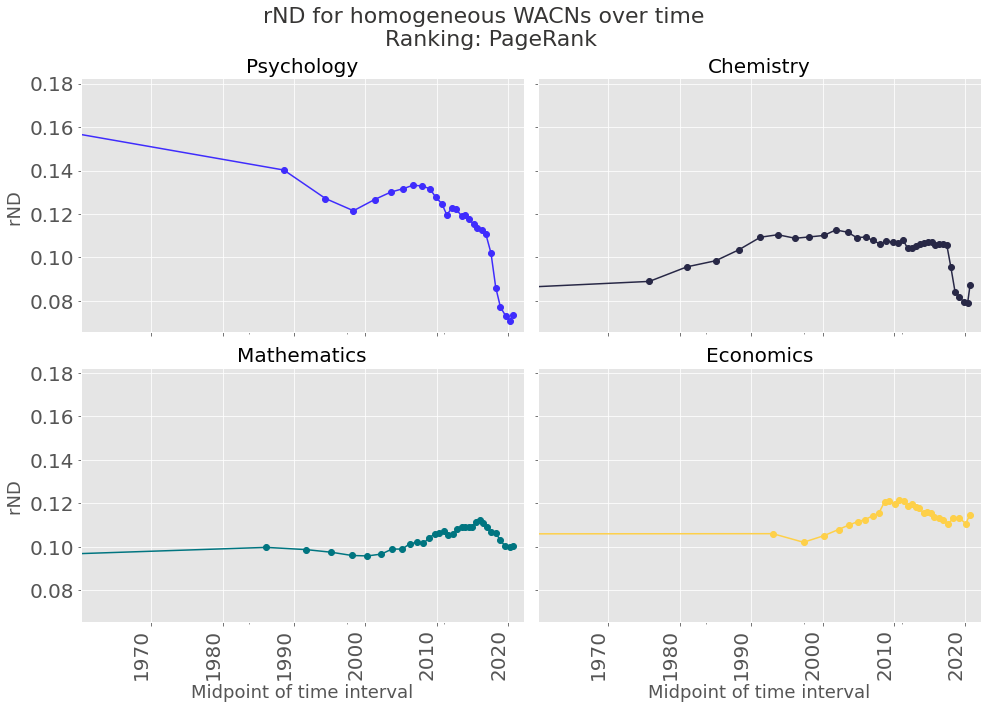

In [82]:
x = plot_slices(figsize=(14,10))

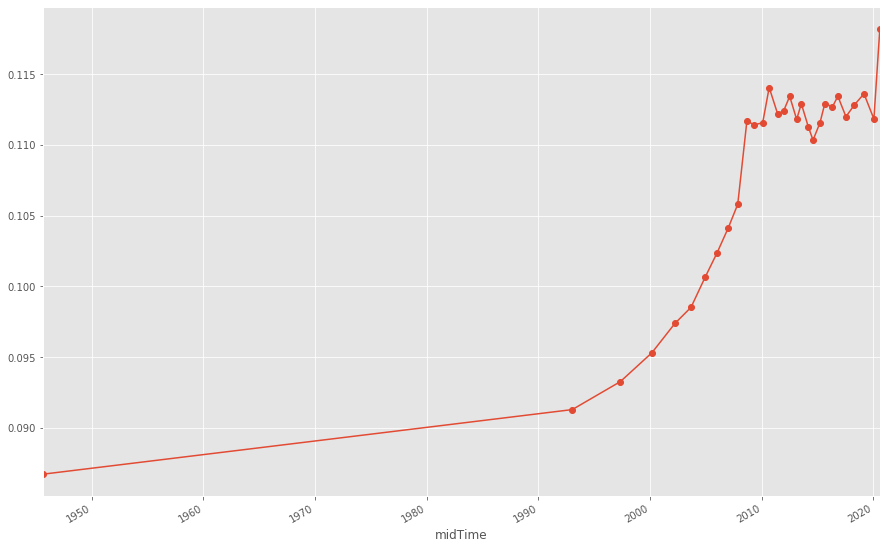

In [118]:
plt.figure()
pd.Series(econ_slices.rND.values, index=econ_slices.midTime).plot(style='-o')
# plt.xticks(econ_slices.pubDate_lower.values)
plt.show()

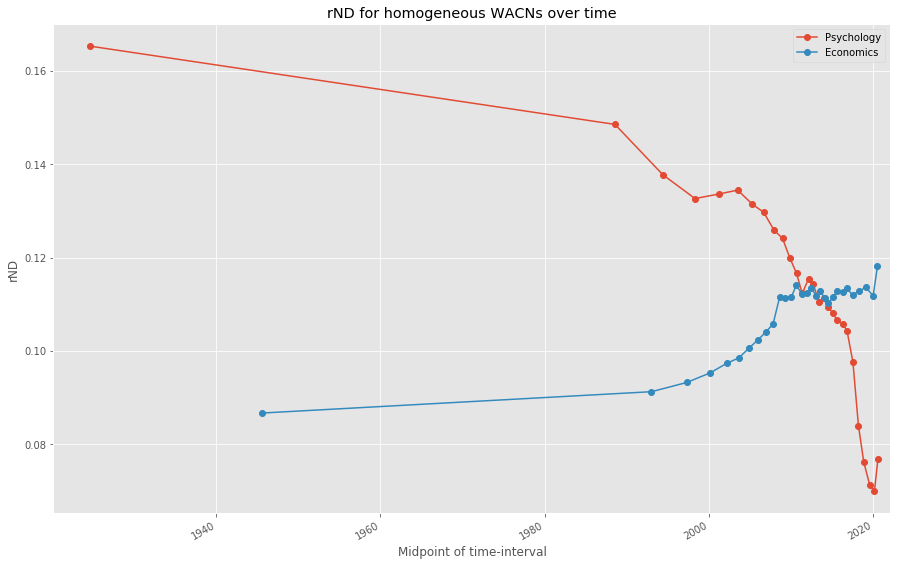

In [133]:
import numpy as np


plt.figure()
pd.Series(psych_slices.rND.values, index=psych_slices.midTime).plot(style='-o', label='Psychology')
pd.Series(econ_slices.rND.values, index=econ_slices.midTime).plot(style='-o', label='Economics')
# plt.xticks(psych_slices.pubDate_lower.values)
plt.xlim((np.datetime64('1920-02-25'), np.datetime64('2022-02-25')))
plt.title("rND for homogeneous WACNs over time")
plt.ylabel('rND')
plt.xlabel('Midpoint of time-interval')
plt.legend()

plt.show()

In [128]:
econ_slices.midTime

0    1945-08-17 00:00:00
1    1993-01-12 00:00:00
2    1997-05-02 12:00:00
3    2000-03-01 12:00:00
4    2002-03-24 12:00:00
5    2003-09-01 00:00:00
6    2004-12-08 00:00:00
7    2006-01-01 00:00:00
8    2007-01-01 00:00:00
9    2007-11-07 00:00:00
10   2008-08-31 00:00:00
11   2009-05-08 00:00:00
12   2010-01-30 12:00:00
13   2010-08-31 12:00:00
14   2011-06-02 00:00:00
15   2011-12-16 00:00:00
16   2012-07-02 00:00:00
17   2013-02-15 00:00:00
18   2013-07-18 00:00:00
19   2014-03-04 00:00:00
20   2014-08-04 12:00:00
21   2015-03-19 00:00:00
22   2015-08-25 12:00:00
23   2016-05-01 00:00:00
24   2016-10-24 12:00:00
25   2017-07-16 00:00:00
26   2018-04-18 12:00:00
27   2019-02-26 00:00:00
28   2020-01-16 00:00:00
29   2020-07-28 00:00:00
Name: midTime, dtype: datetime64[ns]

In [119]:
psych_slices.midTime.values[0] 

numpy.datetime64('1924-08-01T00:00:00.000000000')

In [95]:
pd.Series(econ_slices.rND.values, index=econ_slices.midTime)

midTime
1945-08-17 00:00:00    0.086728
1993-01-12 00:00:00    0.091294
1997-05-02 12:00:00    0.093270
2000-03-01 12:00:00    0.095314
2002-03-24 12:00:00    0.097388
2003-09-01 00:00:00    0.098524
2004-12-08 00:00:00    0.100662
2006-01-01 00:00:00    0.102379
2007-01-01 00:00:00    0.104141
2007-11-07 00:00:00    0.105806
2008-08-31 00:00:00    0.111670
2009-05-08 00:00:00    0.111437
2010-01-30 12:00:00    0.111567
2010-08-31 12:00:00    0.114064
2011-06-02 00:00:00    0.112212
2011-12-16 00:00:00    0.112404
2012-07-02 00:00:00    0.113439
2013-02-15 00:00:00    0.111810
2013-07-18 00:00:00    0.112915
2014-03-04 00:00:00    0.111280
2014-08-04 12:00:00    0.110347
2015-03-19 00:00:00    0.111564
2015-08-25 12:00:00    0.112931
2016-05-01 00:00:00    0.112701
2016-10-24 12:00:00    0.113445
2017-07-16 00:00:00    0.112003
2018-04-18 12:00:00    0.112834
2019-02-26 00:00:00    0.113622
2020-01-16 00:00:00    0.111838
2020-07-28 00:00:00    0.118192
dtype: float64

In [87]:
econ_slices_scores

,index,rND,rKL,rRD,equal_ex
0,0,0.086728,0.010855,0.216475,1.074603
1,1,0.091294,0.011473,0.212389,1.065916
2,2,0.093270,0.012115,0.208445,1.062192
3,3,0.095314,0.012892,0.207669,1.060303
4,4,0.097388,0.013814,0.208388,1.059719
5,5,0.098524,0.013882,0.207660,1.059397
6,6,0.100662,0.014434,0.209817,1.059449
7,7,0.102379,0.014804,0.211694,1.059138
8,8,0.104141,0.015153,0.213268,1.059098
9,9,0.105806,0.016067,0.214385,1.059040


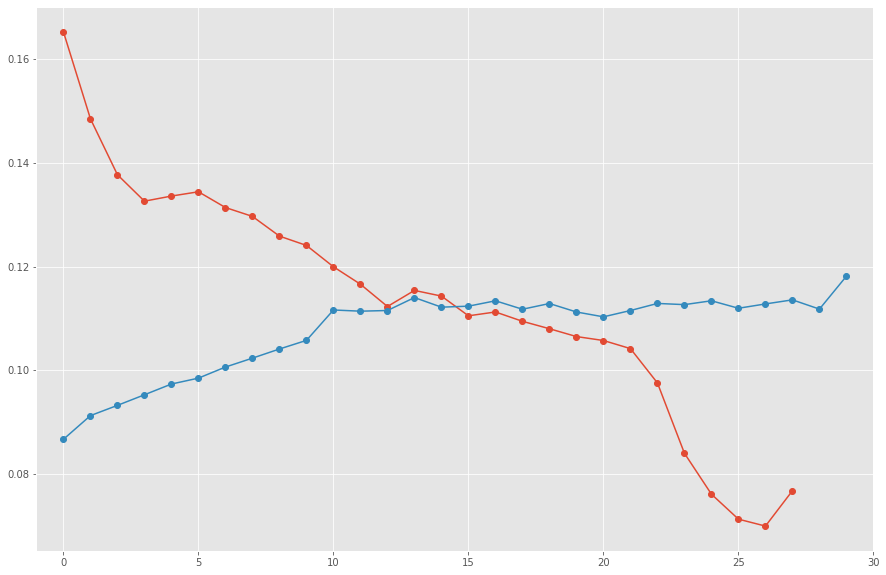

In [64]:
plt.figure()
psych_slices.rND.plot(style='-o', label='Psychology')
econ_slices.rND.plot(style='-o', label='Economics')

plt.xlim((-1, 30))
plt.show()

## Network viz

In [ ]:
fitoutput_indegree = powerlaw.Fit(cent_df['InDegree'].values)
fitoutput_indstrength = powerlaw.Fit(cent_df['InDegreeStrength'].values)

In [ ]:
def plot_ccdf_with_fits(fitoutput, title="CCDF"):
    """
    Plots complement of a cumulative distribution (CCDF) from the output of a 
    degree distribution fitted using the powerlaw package
        @fitoutput: Output of powerlaw.Fit() to the degree distribution of a network 
    """
    plt.figure()
    fig1 = fitoutput.plot_ccdf(label='CCDF', linestyle='--', marker='o')
    
    # add fitted powerlaw, exponential and lognormal CCDF plots as dashed lines
    fitoutput.power_law.plot_ccdf(ax=fig1, color='r', linestyle='--', label='power-law fit')
    fitoutput.exponential.plot_ccdf(ax=fig1, color='g', linestyle='--', label='exponential fit')
    fitoutput.lognormal.plot_ccdf(ax=fig1, color='b', linestyle='--', label='lognormal fit')
    fitoutput.truncated_power_law.plot_ccdf(ax=fig1, color='k', linestyle='--', label='Powerlaw w. exp. cutoff')

    plt.title(title)
    plt.legend()
    plt.ylim(0.001, 1.2)
    plt.xlabel('$x$')
    plt.ylabel('$P(k>=x)$')
    plt.show()

In [ ]:
plot_ccdf_with_fits(fitoutput_indstrength, "CCDF with distribution fits for in-degree")

In [ ]:
plot_ccdf_with_fits(fitoutput_indstrength, "CCDF with distribution fits for in-degree strength")

In [ ]:
plt.figure()
fitoutput_indstrength.plot_pdf(marker='o', linewidth=0, linear_bins=True)
plt.title("PDF for in-degree strength")
plt.xlabel("Strength")
plt.show()